In [39]:
from typing import Union
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pathlib import Path

def dominant_colors(
    img: Union[str, np.ndarray],
    n: int = 5,
    std: float = 0.0,
) -> np.ndarray:
    # --- Load image ---
    if isinstance(img, str):
        pil = Image.open(img).convert("RGB")
        arr = np.asarray(pil)
    elif isinstance(img, np.ndarray):
        arr = img
        # Coerce to RGB uint8 if needed
        if arr.ndim != 3 or arr.shape[2] != 3:
            # Try to interpret via PIL for safety (handles grayscale/alpha)
            pil = Image.fromarray(
                (np.clip(arr, 0, 255)).astype(np.uint8) if arr.dtype != np.uint8 else arr
            ).convert("RGB")
            arr = np.asarray(pil)
        else:
            # If float-like in [0,1], scale to [0,255]
            if np.issubdtype(arr.dtype, np.floating):
                if arr.max() <= 1.0:
                    arr = (arr * 255.0).round().astype(np.uint8)
                else:
                    arr = np.clip(arr, 0, 255).round().astype(np.uint8)
            elif arr.dtype != np.uint8:
                arr = np.clip(arr, 0, 255).astype(np.uint8)
    else:
        raise TypeError("img must be a file path (str) or an RGB numpy array (H, W, 3).")

    # --- Optional Gaussian blur ---
    if std > 0:
        # Work in float, blur per-channel, then back to uint8
        arr_f = arr.astype(np.float32)
        # Apply same sigma to each channel
        for c in range(3):
            arr_f[..., c] = gaussian_filter(arr_f[..., c], sigma=std, mode="reflect")
        arr = np.clip(arr_f, 0, 255).round().astype(np.uint8)

    # --- Flatten pixels for clustering ---
    pixels = arr.reshape(-1, 3).astype(np.float32)

    # --- K-means clustering ---
    # Note: using n_init=10 for broad sklearn compatibility.
    km = KMeans(n_clusters=n, n_init=10)
    labels = km.fit_predict(pixels)  # (N,)
    centers = km.cluster_centers_      # (n, 3) float

    # --- Order clusters by size (descending) ---
    counts = np.bincount(labels, minlength=n)
    order = np.argsort(-counts)  # largest first
    ordered_centers = centers[order]

    # --- Return uint8 RGB colors ---
    colors = np.clip(np.rint(ordered_centers), 0, 255).astype(np.uint8)
    return colors


#image_path ="/home/jloch/album_rater/output_spotify/images/savant-protos-2014.png"
image_paths = Path("output_spotify/images").glob("*.png")
image_path = np.random.choice(list(image_paths))
image = np.array(Image.open(image_path).convert("RGB"))
colors = dominant_colors(image, n=10, std=0.0)



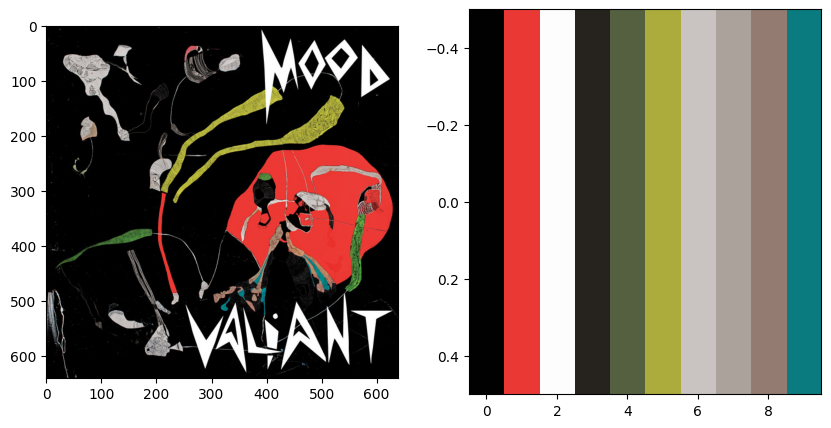

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image*1)
plt.subplot(1,2,2)
plt.imshow([colors],aspect='auto')